In [2]:
import pickle
import numpy as np
import scipy.stats
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, DataGenerator

from sklearn.metrics import r2_score
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize

In [3]:
"""some plotting helpers"""

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (8,6)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 1.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

In [74]:
"""some helper dictionaries"""

eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

labels = {'edens': '$n_e$ ($10^{19}/m^3$)',
          'etemp': '$T_e$ (keV)',
          'itemp': '$T_i$ (keV)',
          'rotation':'$\Omega$ (kHz)',
          'q':'$\iota$',
          'press':'$P$ (Pa)',
         'ffprime':"$FF'$"}

labels = {key:labels[val] for key, val in eq_sigs.items()}

scatter_titles = {'mean':'Mean',
                  'std':'Std Dev.',
                  'pca_1':'PCA Mode 1',
                  'pca_2':'PCA Mode 2',
                  'pca_3':'PCA Mode 3',
                  'pca_4':'PCA Mode 4',
                  'pca_5':'PCA Mode 5',
                  'pca_6':'PCA Mode 6',
                  'pca_2':'PCA Mode 2'}

In [8]:
"""load the scenario"""

with open('/projects/EKOLEMEN/profile_predictor/RCN_results_05_20/20May20-12-48_params.pkl','rb') as f:
    scenario = pickle.load(f,encoding='latin1')

In [16]:
"""load the raw data into a big dictionary"""

base_dir = '/projects/EKOLEMEN/profile_predictor/RCN_results_05_20/eval/'
files = os.listdir(base_dir)

rawdata = {'test':{},
          'train':{},
          'valid':{}}

for file in files:
    with open(base_dir + file,'rb') as f:
        data = pickle.load(f,encoding='latin1')
    rawdata[file.split('_')[0]][data['shotnum']] = data
    


In [40]:
"""reorganize into nested dict, concatenate data into big arrays"""

groups = ['train','test','valid']
levels = ['pred_L1','pred_L2','target']
profiles = scenario['target_profile_names']
alldata = {group:{level:{profile:[] for profile in profiles} for level in levels} for group in groups}

for group in groups:
    for data in rawdata[group].values():
        for level in levels:
            for profile in profiles:
                if profile + '_' + level in data.keys():
                    alldata[group][level][profile].append(data[profile + '_' + level])
alldata = {group:{level:{profile:np.concatenate(alldata[group][level][profile]) for profile in profiles} for level in levels} for group in groups}

In [59]:
"""load PCA fitters"""

with open('/projects/EKOLEMEN/profile_predictor/full_pca_fitters.pkl','rb') as f:
    full_pca_fitters = pickle.load(f, encoding='latin1')
with open('/projects/EKOLEMEN/profile_predictor/delta_pca_fitters.pkl','rb') as f:
    delta_pca_fitters = pickle.load(f, encoding='latin1')

full_pca_fitters['q'] = full_pca_fitters['q_EFIT01']
delta_pca_fitters['q'] = delta_pca_fitters['q_EFIT01']

In [60]:
"""helper functions"""   
def scalarize_mean(arr, **kwargs):
    return np.mean(arr)

def scalarize_std(arr, **kwargs):
    return np.std(arr)

def scalarize_pca_1(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[0]
    return ret

def scalarize_pca_2(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[1]
    return ret

def scalarize_pca_3(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[2]
    return ret

def scalarize_pca_4(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[3]
    return ret

def scalarize_pca_5(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[4]
    return ret

def scalarize_pca_6(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[5]
    return ret

def find_bounds(true,pred,percentile=90):
    arr = np.concatenate([true,pred]).flatten()
  
    true_bounds=(np.percentile(true, 50-percentile/2),np.percentile(true, 50+percentile/2))
    pred_bounds=(np.percentile(pred, 50-percentile/2),np.percentile(pred, 50+percentile/2))
    return (np.maximum(true_bounds[0],pred_bounds[0]),np.minimum(true_bounds[1],pred_bounds[1]))

# Which data to analyze:

In [94]:
group = 'valid'
level = 'pred_L1'

predictions = alldata[group][level]
baseline = alldata[group]['target']

"""also need to downsample profles by 2 to work with PCA fitters"""

predictions = {key:val[:,::2] for key, val in predictions.items()}
baseline = {key:val[:,::2] for key, val in baseline.items()}

psi = np.linspace(0,1,33)

In [95]:
"""calculate errors"""

model_err = {sig: np.abs(predictions[sig] - baseline[sig]) for sig in scenario['target_profile_names']}
baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}


In [96]:
"""get median and 25/75 percentile errors, denormalized, for model and baseline"""

hi_per = 75
low_per = 25

med_model_err = {sig:np.median(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

hiper_model_err = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
hiper_baseline_err = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

lowper_model_err = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
lowper_baseline_err = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}


In [97]:
"""get PCA coeffs"""

fitter = delta_pca_fitters
scalarize_functions = [scalarize_mean, scalarize_pca_1,scalarize_pca_2]
scalarize_function_names = [fun.__name__[10:] for fun in scalarize_functions]
profiles = scenario['target_profile_names']

num_samples = len(baseline[list(baseline.keys())[0]])

all_true_delta = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}
all_predicted_delta = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}

n=1
nmax = len(profiles)*num_samples*len(scalarize_functions)
for j,profile in enumerate(profiles):
    for k in range(num_samples):
        target = baseline[profile][k][np.newaxis,:]
        pred = predictions[profile][k][np.newaxis,:]
        for i,scalarize in enumerate(scalarize_functions):
            all_true_delta[profile][scalarize_function_names[i]][k] = scalarize(target, fitter=fitter[profile])
            all_predicted_delta[profile][scalarize_function_names[i]][k] = scalarize(pred, fitter=fitter[profile])  
            print('{}/{}'.format(n,nmax),end='\r')
            n += 1


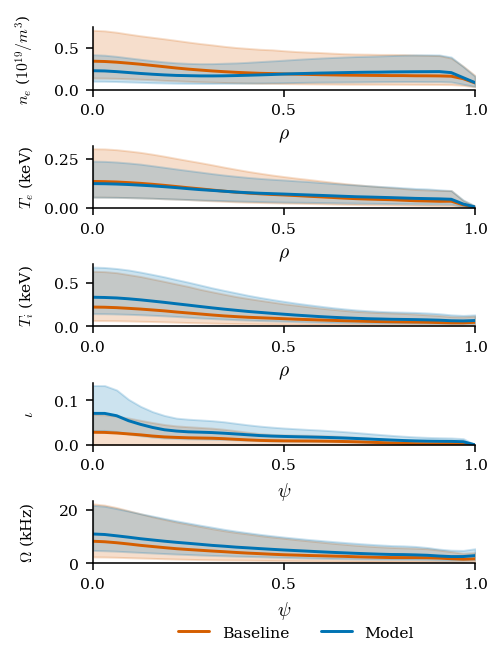

In [98]:
profiles = scenario['target_profile_names']

fig, ax = plt.subplots(len(profiles),1,figsize=(3.5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline',lw=1.5)
    ax[i].fill_between(psi,lowper_baseline_err[sig],hiper_baseline_err[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model',lw=1.5)
    ax[i].fill_between(psi,lowper_model_err[sig],hiper_model_err[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[sig],size=8)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=10)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=10)

plt.subplots_adjust(hspace=0.9, bottom=0.12)
fig.align_ylabels(ax)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=8);
# fig.savefig('images/average_error.pdf',bbox_inches='tight',pad_inches=0.1)
# fig.savefig('images/average_error.png',bbox_inches='tight',pad_inches=0.1)

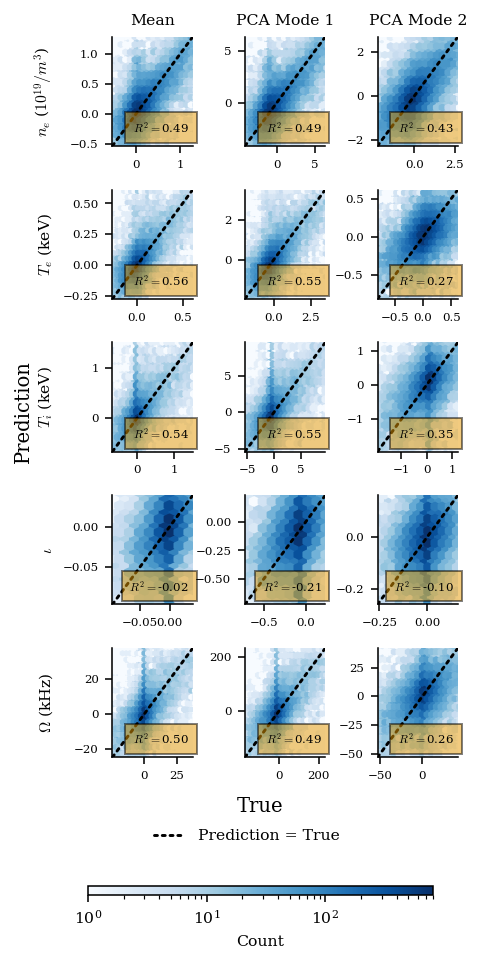

In [99]:
"""scatter plot of deltas with r^2"""

profiles = scenario['target_profile_names']



fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), figsize=(3.5,7))

for i,profile in enumerate(profiles):
    for j,name in enumerate(scalarize_function_names):

        pred=copy.deepcopy(all_predicted_delta[profile][name])
        true=copy.deepcopy(all_true_delta[profile][name])

        ax = axes[i,j]
        pred *= scenario['normalization_dict'][profile]['iqr']
        true *= scenario['normalization_dict'][profile]['iqr']
        
        bounds = find_bounds(true,pred,95)
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)

        r2_model = r2_score(true,pred)

        hb = ax.hexbin(true,pred,gridsize=100,bins='log',mincnt=0,cmap='Blues')
        ax.text(0.95, 0.1, '$R^2=${:.2f}'.format(r2_model), fontsize=6, horizontalalignment='right',verticalalignment='bottom', 
                transform=ax.transAxes,bbox=dict(facecolor=colorblind_colors[-1], alpha=0.5))

        x_45 = np.linspace(*ax.get_xlim())
        ax.plot(x_45, x_45,color='k', linestyle=':',lw=1.5,label='Prediction = True')
        if i == 0:
            ax.set_title(scatter_titles[name], size=8)
        if j == 0:
            ax.set_ylabel(labels[profile], size=8)

        ax.tick_params(axis='both', which='major', labelsize=6)


plt.subplots_adjust(hspace=0.4,wspace=0.65,bottom=0.15, left=0.2)

fig.text(0.5, 0.1, 'True', va='center', ha='center', fontsize=10)
fig.text(0.02, 0.5, 'Prediction', va='center', ha='center', rotation='vertical', fontsize=10)

fig.align_ylabels(axes[:,0])



cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.01])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal', fraction=.3)
cb.set_label('Count', size=8)
cb.ax.tick_params(labelsize=8)

fig.legend(handles=axes[0,0].lines,     
           labels=[line._label for line in axes[0,0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.5, 0.15),
           frameon=False,
           mode=None,
           ncol=2,
           fontsize=8);
# fig.savefig('images/all_pca_acc.pdf',bbox_inches='tight',pad_inches=0.1)
# fig.savefig('images/all_pca_acc.png',bbox_inches='tight',pad_inches=0.1)